In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
import seaborn as sns
import cv2
import time

# For preprocessing of images
import torch

from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable

# For neural network
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.parameter import Parameter
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax, leaky_relu

# For confusion matrix
from sklearn import metrics

# Setup of preprocessing of images
normalize = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
)
size = 128
preprocess = transforms.Compose([
    transforms.Pad((0,80)),
    transforms.Resize(size),
    transforms.ToTensor(),
    normalize
])

# For drawing lines based on angles
def rotate_around_point_highperf(xy, radians, origin=(0, 0)):
    """Rotate a point around a given point.
    
    I call this the "high performance" version since we're caching some
    values that are needed >1 time. It's less readable than the previous
    function but it's faster.
    """
    x, y = xy
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    return qx, qy

def draw_lines(img, px, py, t, lineThickness=5, l=150, col=(0,255,0)):
    px1 = px - l/2
    px2 = px + l/2
    py1 = py
    py2 = py
    O = [px, py]

    A = [px1, py1]
    B = [px2, py2]


    tempx = rotate_around_point_highperf(A, t, O)
    tempy = rotate_around_point_highperf(B, t, O)

    cv2.line(img, (int(tempx[0]), int(tempx[1])), (int(tempy[0]), int(tempy[1])),
            col, lineThickness)
    
    l = l/4
    px1 = px - l/2
    px2 = px + l/2
    py1 = py
    py2 = py
    O = [px, py]

    A = [px1, py1]
    B = [px2, py2]
    t = t + math.pi/2


    tempx = rotate_around_point_highperf(A, t, O)
    tempy = rotate_around_point_highperf(B, t, O)

    cv2.line(img, (int(tempx[0]), int(tempx[1])), (int(tempy[0]), int(tempy[1])),
            col, lineThickness)

# For dotted lines
def drawline(img,pt1,pt2,color,thickness=1,style='dotted',gap=20):
    dist =((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)**.5
    pts= []
    for i in  np.arange(0,dist,gap):
        r=i/dist
        x=int((pt1[0]*(1-r)+pt2[0]*r)+.5)
        y=int((pt1[1]*(1-r)+pt2[1]*r)+.5)
        p = (x,y)
        pts.append(p)

    if style=='dotted':
        for p in pts:
            cv2.circle(img,p,thickness,color,-1)
    else:
        s=pts[0]
        e=pts[0]
        i=0
        for p in pts:
            s=e
            e=p
            if i%2==1:
                cv2.line(img,s,e,color,thickness)
            i+=1

def drawpoly(img,pts,color,thickness=1,style='dotted',):
    s=pts[0]
    e=pts[0]
    pts.append(pts.pop(0))
    for p in pts:
        s=e
        e=p
        drawline(img,s,e,color,thickness,style)

def drawrect(img,pt1,pt2,color,thickness=1,style='dotted'):
    pts = [pt1,(pt2[0],pt1[1]),pt2,(pt1[0],pt2[1])] 
    drawpoly(img,pts,color,thickness,style)

In [2]:
load_weights = True
load_weights_str = "FullModel_5992_2000.py"
save_weights = False
save_weights_str = "FullModel.py"

In [3]:
# Loading data
X = np.load("data/Resized_pictures_128x128_8978.npy")
y = np.load("data/data_128x128_8978.npy")

In [4]:
# Output layer size dependent on desired predictions
class_mapping = ('blue','green','red','yellow','empty')
n_regs = 3
n_classes = len(class_mapping)

In [5]:
# Splitting data in training- and test-set
np.random.seed(5992)

s = round(len(X)*0.8)
      
idx = np.arange(0,len(X))
rand_idx = np.random.choice(idx, s, replace=False)
X_train = X[rand_idx]
y_train = y[rand_idx]
X_test = [x for i, x in enumerate(X) if i not in rand_idx]
y_test = [x for i, x in enumerate(y) if i not in rand_idx]

y_train = torch.from_numpy(y_train)
y_train = y_train.float()

y_test = np.array(y_test)
y_test = torch.from_numpy(y_test)
y_test = y_test.float()

X_test = np.array(X_test)
X_test = torch.from_numpy(X_test)

X_train = torch.from_numpy(X_train)

In [6]:
# Checking for cuda availability
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [7]:
# hyperameters of the model
channels = X_train.shape[1]
height = X_train.shape[2]
width = X_train.shape[3]
# convolutional layer parameters
num_filters_conv1 = 16
num_filters_conv2 = 32
num_filters_conv3 = 63
kernel_size_conv1 = 7 # [height, width]
kernel_size_conv2 = 5
kernel_size_conv3 = 3
stride_conv1 = 1 # [stride_height, stride_width]
stride_conv2 = 1
stride_conv3 = 1
# max pooling layer parameters
kernel_size_max1 = 2
kernel_size_max2 = 2
kernel_size_max3 = 2
stride_max1 = 2
stride_max2 = 2
stride_max3 = 2
# hidden layer parameter
num_l1 = 64

class Net(nn.Module):
    def __init__(self, n_regs, n_classes):
        super(Net, self).__init__()
        self.n_regs = n_regs
        self.n_classes = n_classes        
        
        self.conv_1 = Conv2d(in_channels=channels,
                            out_channels=num_filters_conv1,
                            kernel_size=kernel_size_conv1,
                            stride=stride_conv1)
        
        self.conv_2 = Conv2d(in_channels=num_filters_conv1,
                            out_channels=num_filters_conv2,
                            kernel_size=kernel_size_conv2,
                            stride=stride_conv2)
        
        self.conv_3 = Conv2d(in_channels=num_filters_conv2,
                            out_channels=num_filters_conv3,
                            kernel_size=kernel_size_conv3,
                            stride=stride_conv3)
        
        self.pool_1 = MaxPool2d(kernel_size=kernel_size_max1,
                                stride=stride_max1,
                                padding=0)
        
        self.pool_2 = MaxPool2d(kernel_size=kernel_size_max2,
                                stride=stride_max2,
                                padding=0)
        
        self.pool_3 = MaxPool2d(kernel_size=kernel_size_max3,
                                stride=stride_max3,
                                padding=0)
        
        self.l1_in_features = 10647 
        
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        
        self.l_out1 = Linear(in_features=num_l1, 
                            out_features=n_regs,
                            bias=False)
        
        self.l_out2 = Linear(in_features=num_l1, 
                            out_features=n_classes,
                            bias=False)
        
        
    def forward(self, x):
        # Convolutional layers
        x = self.conv_1(x)
        x = self.pool_1(x)
        x = relu(x)
        
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = relu(x)
        
        x = self.conv_3(x)
        x = self.pool_3(x)
        x = relu(x)

        # flatten
        x = x.view(-1, self.l1_in_features)
        
        # hidden layer
        x = self.l_1(x)
        x = relu(x)
        
        # Output layers
        x1 = self.l_out1(x)
        x2 = softmax(self.l_out2(x), dim=1)
        return x1, x2
    

net = Net(n_regs,n_classes)
print(net)

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv_3): Conv2d(32, 63, kernel_size=(3, 3), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l_1): Linear(in_features=10647, out_features=64, bias=True)
  (l_out1): Linear(in_features=64, out_features=3, bias=False)
  (l_out2): Linear(in_features=64, out_features=5, bias=False)
)


In [8]:
# Setting optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.001)

In [9]:
lambda_x = 200
lambda_y = 200
lambda_th = 200
lambda_color = 1

def custom_loss(outputs1, outputs2, targets):
    # MSE for X and Y values
    lossx = lambda_x*F.mse_loss(outputs1[:,0],targets[:,0])
    lossy = lambda_y*F.mse_loss(outputs1[:,1],targets[:,1])
    lossth = lambda_th*F.mse_loss(outputs1[:,2],targets[:,2])
    
    # Cross entropy for color classes
    losscolor = lambda_color*F.cross_entropy(outputs2,targets[:,3].type('torch.cuda.LongTensor'))
    
    return lossx,lossy,lossth,losscolor

In [10]:
if not load_weights:
    if use_cuda:
        net = net.cuda()
        print("Used Cuda")
    else:
        print("Didn't use Cuda")
    
    num_epoch = 30
    batch_size = 8

    for epoch in range(num_epoch):

        running_lossx = 0.0
        running_lossy = 0.0
        running_lossth = 0.0
        running_losscolor = 0.0

        for i in range(round(len(y_train)/batch_size)):
            # get the inputs
            inputs = X_train[batch_size*i:(i+1)*batch_size]
            labels = y_train[batch_size*i:(i+1)*batch_size]
            
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs1, outputs2 = net(inputs)
                        
            if batch_size == 1:
                lossx,lossy,lossth,losscolor = custom_loss(outputs1,outputs2,labels)
            else:
                lossx,lossy,lossth,losscolor = custom_loss(outputs1.squeeze(),outputs2.squeeze(),labels)
            loss = lossx+lossy+lossth+losscolor
            loss.backward()
            
            optimizer.step()

            # print statistics
            running_lossx += lossx.item()
            running_lossy += lossy.item()
            running_lossth += lossth.item()
            running_losscolor += losscolor.item()
            every = 100
            if i % every == every-1:
                print("[{}, {}] lossx: {:.6f} | lossy: {:.6f} | lossth: {:.6f} | losscolor: {:.6f}".format(epoch + 1, i + 1, running_lossx / every, 
                                                                                                           running_lossy / every, running_lossth / every,
                                                                                                           running_losscolor / every))
                running_lossx = 0.0
                running_lossy = 0.0
                running_lossth = 0.0
                running_losscolor = 0.0

    print('Finished Training')

In [11]:
# Loading alternative
if load_weights:
    net = torch.load(load_weights_str)
    net.eval()
    net = net.cuda()
    print("Loaded weights")

Loaded weights


In [12]:
batch_size = 1
error = 0
SSEx = 0
SSEy = 0
SSEth = 0
wrong = 0
right = 0

confidences_correct = []
confidences_incorrect = []

y_pred = []

x_err = []
y_err = []

for i in range(round(len(y_test)/batch_size)):
    images = X_test[batch_size*i:(i+1)*batch_size]
    labels = y_test[batch_size*i:(i+1)*batch_size]
    
    images = images.cuda()
    labels = labels.cuda()
    
    outputs1, outputs2 = net(Variable(images))
    conf, predicted = torch.max(outputs2.data, 1)
    
    x_t = labels[0,0].item()
    x_p = outputs1[0,0].item()
    y_t = labels[0,1].item()
    y_p = outputs1[0,1].item()
    th_t = labels[0,2].item()
    th_p = outputs1[0,2].item()
    color_t = int(labels[0,3].item())
    color_p = int(predicted.item())
    
    x_err.append(x_t-x_p)
    y_err.append(y_t-y_p)
    
    if batch_size == 1:
        SEx = (x_t-x_p)**2
        SEy = (y_t-y_p)**2
        SEth = (th_t-th_p)**2
    else:
        SEx = ((x_t-x_p)**2).mean()
        SEy = ((y_t-y_p)**2).mean()
        SEth = ((th_t-th_p)**2).mean()
    
    if i == 0:
        print("Actual / Predicted")
    print("{} | x: {:.4f} / {:.4f} | y: {:.4f} / {:.4f} | th: {:.4f} / {:.4f} | color: {} / {} |".format(i, x_t, x_p, y_t, y_p, th_t, th_p, color_t, color_p))
    
    SSEx += SEx
    SSEy += SEy
    SSEth += SEth
    if color_t == color_p:
        right += 1
        confidences_correct.append(conf.item())
    else:
        wrong += 1
        confidences_incorrect.append(conf.item())
    y_pred.append(color_p)

acc = right/(wrong+right)

MSEx = SSEx / len(y_test)
MSEy = SSEy / len(y_test)
MSEth = SSEth / len(y_test)
TMSE = MSEx+MSEy+MSEth

RMSE = math.sqrt(TMSE)
RMSEx = math.sqrt(MSEx)
RMSEy = math.sqrt(MSEy)
RMSEth = math.sqrt(MSEth)

print("RMSE: {:.6f}  =  RMSEx: {:.6f}  +  RMSEy: {:.6f}  +  RMSEth: {:.6f}".format(RMSE,RMSEx,RMSEy,RMSEth))
print("Accuracy: {:.5f}".format(acc))

Actual / Predicted
0 | x: 0.7923 / 0.7930 | y: 0.8509 / 0.8976 | th: 0.0404 / 0.0147 | color: 2 / 2 |
1 | x: 0.6052 / 0.6041 | y: 0.9483 / 0.9757 | th: 0.1013 / 0.1117 | color: 2 / 2 |
2 | x: 0.6793 / 0.6710 | y: 0.6368 / 0.6537 | th: 0.0443 / 0.0566 | color: 2 / 2 |
3 | x: 0.1523 / 0.1524 | y: 0.5998 / 0.5917 | th: 0.1628 / 0.1693 | color: 2 / 2 |
4 | x: 0.5453 / 0.5479 | y: 0.2212 / 0.2193 | th: 0.4273 / 0.4273 | color: 2 / 2 |
5 | x: 0.9089 / 0.9182 | y: 0.1565 / 0.1477 | th: 0.1177 / 0.1385 | color: 2 / 2 |
6 | x: 0.1592 / 0.1756 | y: 0.6810 / 0.7095 | th: 0.4676 / 0.4719 | color: 2 / 2 |
7 | x: 0.9834 / 0.9716 | y: 0.4849 / 0.4741 | th: 0.1932 / 0.2247 | color: 2 / 2 |
8 | x: 0.7936 / 0.8117 | y: 0.3973 / 0.3959 | th: 0.1548 / 0.1735 | color: 2 / 2 |
9 | x: 0.9933 / 0.9475 | y: 0.7989 / 0.7969 | th: 0.4149 / 0.3997 | color: 2 / 2 |
10 | x: 0.9905 / 1.0018 | y: 0.2276 / 0.2325 | th: 0.6036 / 0.6094 | color: 2 / 2 |
11 | x: 0.2439 / 0.2492 | y: 0.2153 / 0.2034 | th: 0.9516 / 0.9685 

97 | x: 0.0008 / -0.0040 | y: 0.2665 / 0.2354 | th: 0.2580 / 0.1973 | color: 3 / 3 |
98 | x: 0.0939 / 0.1080 | y: 0.6394 / 0.6594 | th: 0.4367 / 0.4733 | color: 3 / 3 |
99 | x: 0.7437 / 0.7657 | y: 0.3172 / 0.3289 | th: 0.5433 / 0.5339 | color: 3 / 3 |
100 | x: 0.0024 / 0.0094 | y: 0.1122 / 0.1104 | th: 0.3013 / 0.3001 | color: 3 / 3 |
101 | x: 0.3903 / 0.4184 | y: 0.1039 / 0.0720 | th: 0.9673 / 0.9761 | color: 3 / 3 |
102 | x: 0.9170 / 0.9268 | y: 0.9263 / 0.9576 | th: 0.9941 / 0.9742 | color: 3 / 3 |
103 | x: 0.5114 / 0.5342 | y: 0.0947 / 0.0950 | th: 0.0709 / 0.1148 | color: 3 / 3 |
104 | x: 0.0535 / 0.0376 | y: 0.9537 / 1.0391 | th: 0.9121 / 0.9474 | color: 3 / 3 |
105 | x: 0.4072 / 0.4224 | y: 0.5204 / 0.5273 | th: 0.0486 / 0.0585 | color: 0 / 0 |
106 | x: 0.5537 / 0.5514 | y: 0.9345 / 0.9648 | th: 0.6505 / 0.6815 | color: 0 / 0 |
107 | x: 0.1761 / 0.2047 | y: 0.9651 / 0.9376 | th: 0.6162 / 0.5781 | color: 0 / 0 |
108 | x: 0.3486 / 0.3451 | y: 0.6084 / 0.6158 | th: 0.0785 / 0.0859

193 | x: 0.1790 / 0.1876 | y: 0.4963 / 0.4870 | th: 0.0452 / 0.0263 | color: 1 / 1 |
194 | x: 0.9438 / 0.9717 | y: 0.6272 / 0.6335 | th: 0.8242 / 0.8632 | color: 1 / 1 |
195 | x: 0.1555 / 0.1543 | y: 0.5845 / 0.5883 | th: 0.8506 / 0.8699 | color: 1 / 1 |
196 | x: 0.0177 / 0.0378 | y: 0.4619 / 0.4481 | th: 0.7482 / 0.7537 | color: 1 / 1 |
197 | x: 0.9752 / 0.9616 | y: 0.3790 / 0.3697 | th: 0.6488 / 0.6557 | color: 1 / 1 |
198 | x: 0.3311 / 0.3497 | y: 0.7219 / 0.7267 | th: 0.8483 / 0.8588 | color: 1 / 1 |
199 | x: 0.2701 / 0.2800 | y: 0.5935 / 0.5843 | th: 0.1704 / 0.1691 | color: 1 / 1 |
200 | x: 0.5896 / 0.5848 | y: 0.6469 / 0.6606 | th: 0.4641 / 0.4572 | color: 1 / 1 |
201 | x: 0.4970 / 0.5093 | y: 0.6852 / 0.6944 | th: 0.8939 / 0.9540 | color: 1 / 1 |
202 | x: 0.6240 / 0.6323 | y: 0.3603 / 0.3705 | th: 0.5283 / 0.5336 | color: 1 / 1 |
203 | x: 0.9736 / 0.9993 | y: 0.8066 / 0.8461 | th: 0.0624 / 0.0554 | color: 1 / 1 |
204 | x: 0.5516 / 0.5703 | y: 0.2348 / 0.2266 | th: 0.8436 / 0.88

289 | x: 0.6991 / 0.7058 | y: 0.4033 / 0.3986 | th: 0.7294 / 0.7229 | color: 2 / 2 |
290 | x: 0.1657 / 0.1536 | y: 0.5517 / 0.5493 | th: 0.0175 / 0.0189 | color: 2 / 2 |
291 | x: 0.6960 / 0.6811 | y: 0.2323 / 0.2435 | th: 0.2953 / 0.3082 | color: 2 / 2 |
292 | x: 0.8218 / 0.8024 | y: 0.0308 / 0.0529 | th: 0.3581 / 0.3421 | color: 2 / 2 |
293 | x: 0.9655 / 0.9844 | y: 0.9700 / 1.0045 | th: 0.1731 / 0.1761 | color: 2 / 2 |
294 | x: 0.2580 / 0.2656 | y: 0.7031 / 0.7215 | th: 0.7337 / 0.7405 | color: 2 / 2 |
295 | x: 0.0672 / 0.0754 | y: 0.1515 / 0.1486 | th: 0.3965 / 0.3671 | color: 2 / 2 |
296 | x: 0.2404 / 0.2595 | y: 0.1811 / 0.1868 | th: 0.7866 / 0.7658 | color: 2 / 2 |
297 | x: 0.1362 / 0.1577 | y: 0.0486 / 0.0772 | th: 0.6773 / 0.6842 | color: 2 / 2 |
298 | x: 0.5238 / 0.5387 | y: 0.7097 / 0.7219 | th: 0.6660 / 0.6870 | color: 2 / 2 |
299 | x: 0.0263 / 0.0397 | y: 0.0061 / -0.0027 | th: 0.6635 / 0.6064 | color: 2 / 2 |
300 | x: 0.2015 / 0.2186 | y: 0.7762 / 0.7796 | th: 0.8473 / 0.8

385 | x: 0.3827 / 0.3965 | y: 0.9620 / 0.9728 | th: 0.7114 / 0.7288 | color: 1 / 1 |
386 | x: 0.2893 / 0.2905 | y: 0.9177 / 0.9162 | th: 0.7909 / 0.8050 | color: 1 / 1 |
387 | x: 0.5939 / 0.5957 | y: 0.9316 / 0.9212 | th: 0.6471 / 0.6423 | color: 1 / 1 |
388 | x: 0.9055 / 0.9042 | y: 0.3524 / 0.3648 | th: 0.8189 / 0.8110 | color: 1 / 1 |
389 | x: 0.4090 / 0.3985 | y: 0.6886 / 0.6895 | th: 0.0874 / 0.1071 | color: 1 / 1 |
390 | x: 0.5405 / 0.5463 | y: 0.3135 / 0.3227 | th: 0.2369 / 0.2418 | color: 1 / 1 |
391 | x: 0.4703 / 0.4803 | y: 0.3071 / 0.3255 | th: 0.1291 / 0.1517 | color: 1 / 1 |
392 | x: 0.6102 / 0.6173 | y: 0.8536 / 0.8572 | th: 0.6605 / 0.6607 | color: 1 / 1 |
393 | x: 0.8251 / 0.8306 | y: 0.5936 / 0.5895 | th: 0.8459 / 0.8242 | color: 1 / 1 |
394 | x: 0.7778 / 0.8080 | y: 0.2374 / 0.2325 | th: 0.0360 / 0.0815 | color: 1 / 1 |
395 | x: 0.3158 / 0.3483 | y: 0.2065 / 0.1766 | th: 0.1962 / 0.2055 | color: 1 / 1 |
396 | x: 0.5352 / 0.5390 | y: 0.9735 / 0.9627 | th: 0.8266 / 0.80

481 | x: 0.5226 / 0.5392 | y: 0.3045 / 0.3114 | th: 0.8559 / 0.8375 | color: 3 / 3 |
482 | x: 0.2899 / 0.3038 | y: 0.6057 / 0.5918 | th: 0.1890 / 0.2104 | color: 3 / 3 |
483 | x: 0.1839 / 0.1880 | y: 0.9988 / 1.0185 | th: 0.4049 / 0.3839 | color: 3 / 3 |
484 | x: 0.3471 / 0.3623 | y: 0.6671 / 0.6817 | th: 0.4198 / 0.3994 | color: 3 / 3 |
485 | x: 0.3151 / 0.3260 | y: 0.9964 / 1.0383 | th: 0.7720 / 0.7618 | color: 3 / 3 |
486 | x: 0.6054 / 0.6226 | y: 0.3791 / 0.3738 | th: 0.6383 / 0.6557 | color: 3 / 3 |
487 | x: 0.6134 / 0.6433 | y: 0.3062 / 0.3113 | th: 0.7400 / 0.7769 | color: 3 / 3 |
488 | x: 0.6731 / 0.6886 | y: 0.2697 / 0.3137 | th: 0.9953 / 1.0120 | color: 3 / 3 |
489 | x: 0.4986 / 0.5216 | y: 0.0677 / 0.0724 | th: 0.1107 / 0.1797 | color: 3 / 3 |
490 | x: 0.9453 / 0.9532 | y: 0.6894 / 0.7124 | th: 0.0273 / 0.0481 | color: 3 / 3 |
491 | x: 0.5815 / 0.5764 | y: 0.9989 / 1.0418 | th: 0.0903 / 0.0350 | color: 3 / 3 |
492 | x: 0.6100 / 0.6427 | y: 0.5730 / 0.5871 | th: 0.1198 / 0.08

577 | x: 0.3534 / 0.3595 | y: 0.8110 / 0.8253 | th: 0.2557 / 0.2724 | color: 0 / 0 |
578 | x: 0.0855 / 0.1099 | y: 0.2187 / 0.2179 | th: 0.9304 / 0.8718 | color: 0 / 0 |
579 | x: 0.7377 / 0.7667 | y: 0.6089 / 0.6101 | th: 0.3488 / 0.3558 | color: 0 / 0 |
580 | x: 0.8622 / 0.8847 | y: 0.3010 / 0.3012 | th: 0.5828 / 0.5808 | color: 0 / 0 |
581 | x: 0.0276 / 0.0374 | y: 0.4169 / 0.4006 | th: 0.1603 / 0.0931 | color: 0 / 0 |
582 | x: 0.1773 / 0.2013 | y: 0.7111 / 0.7222 | th: 0.5756 / 0.5608 | color: 0 / 0 |
583 | x: 0.5924 / 0.6061 | y: 0.4195 / 0.4328 | th: 0.6936 / 0.6859 | color: 0 / 0 |
584 | x: 0.7796 / 0.8052 | y: 0.1558 / 0.1532 | th: 0.0857 / 0.1312 | color: 0 / 0 |
585 | x: 0.6072 / 0.6072 | y: 0.4942 / 0.4986 | th: 0.6873 / 0.6795 | color: 0 / 0 |
586 | x: 0.3191 / 0.3327 | y: 0.3926 / 0.4060 | th: 0.0545 / 0.0913 | color: 0 / 0 |
587 | x: 0.7963 / 0.8065 | y: 0.6186 / 0.6262 | th: 0.4948 / 0.4983 | color: 0 / 0 |
588 | x: 0.2592 / 0.2613 | y: 0.6719 / 0.6835 | th: 0.8166 / 0.81

673 | x: 0.2641 / 0.2751 | y: 0.0938 / 0.1136 | th: 0.7331 / 0.7638 | color: 3 / 3 |
674 | x: 0.8423 / 0.8358 | y: 0.9920 / 0.9774 | th: 0.3534 / 0.3603 | color: 2 / 2 |
675 | x: 0.3834 / 0.3795 | y: 0.3995 / 0.3866 | th: 0.9869 / 0.9581 | color: 2 / 2 |
676 | x: 0.8356 / 0.8107 | y: 0.9119 / 0.8909 | th: 0.8971 / 0.8556 | color: 2 / 2 |
677 | x: 0.5072 / 0.5318 | y: 0.6680 / 0.6656 | th: 0.0623 / 0.1440 | color: 2 / 2 |
678 | x: 0.6301 / 0.6302 | y: 0.1124 / 0.1131 | th: 0.2904 / 0.3147 | color: 2 / 2 |
679 | x: 0.4811 / 0.4951 | y: 0.2833 / 0.2771 | th: 0.0188 / 0.0585 | color: 2 / 2 |
680 | x: 0.2263 / 0.2570 | y: 0.2050 / 0.2081 | th: 0.1256 / 0.1249 | color: 2 / 2 |
681 | x: 0.1832 / 0.1833 | y: 0.1003 / 0.1076 | th: 0.4192 / 0.4094 | color: 0 / 0 |
682 | x: 0.9713 / 0.9519 | y: 0.7787 / 0.7905 | th: 0.5648 / 0.5718 | color: 0 / 0 |
683 | x: 0.7916 / 0.8145 | y: 0.5824 / 0.6117 | th: 0.5339 / 0.5220 | color: 0 / 0 |
684 | x: 0.5621 / 0.5809 | y: 0.4983 / 0.5150 | th: 0.2239 / 0.20

769 | x: 0.2818 / 0.2856 | y: 0.6964 / 0.7090 | th: 0.3904 / 0.4040 | color: 0 / 0 |
770 | x: 0.8934 / 0.8853 | y: 0.2468 / 0.2353 | th: 0.9581 / 0.9741 | color: 1 / 1 |
771 | x: 0.7939 / 0.8052 | y: 0.4214 / 0.4202 | th: 0.2503 / 0.2113 | color: 1 / 1 |
772 | x: 0.2006 / 0.2139 | y: 0.6369 / 0.6579 | th: 0.3649 / 0.3598 | color: 1 / 1 |
773 | x: 0.4105 / 0.4190 | y: 0.5907 / 0.6060 | th: 0.0676 / 0.0606 | color: 1 / 1 |
774 | x: 0.6717 / 0.6843 | y: 0.4599 / 0.4615 | th: 0.0084 / 0.0096 | color: 1 / 1 |
775 | x: 0.6956 / 0.7252 | y: 0.4498 / 0.4723 | th: 0.4712 / 0.4923 | color: 1 / 1 |
776 | x: 0.7658 / 0.7842 | y: 0.1008 / 0.1022 | th: 0.6228 / 0.6328 | color: 1 / 1 |
777 | x: 0.0271 / 0.0472 | y: 0.5584 / 0.5737 | th: 0.4339 / 0.4330 | color: 1 / 1 |
778 | x: 0.4408 / 0.4570 | y: 0.1647 / 0.1658 | th: 0.1512 / 0.1659 | color: 3 / 3 |
779 | x: 0.2849 / 0.2879 | y: 0.4368 / 0.4519 | th: 0.0452 / 0.0569 | color: 3 / 3 |
780 | x: 0.7571 / 0.7843 | y: 0.8716 / 0.8956 | th: 0.5047 / 0.53

865 | x: 0.0056 / 0.0113 | y: 0.3481 / 0.3482 | th: 0.8224 / 0.8094 | color: 3 / 3 |
866 | x: 0.0912 / 0.0823 | y: 0.8412 / 0.8596 | th: 0.7747 / 0.8258 | color: 2 / 2 |
867 | x: 0.6336 / 0.6333 | y: 0.5950 / 0.5994 | th: 0.5633 / 0.5792 | color: 2 / 2 |
868 | x: 0.9229 / 0.9153 | y: 0.7033 / 0.7100 | th: 0.9529 / 0.9431 | color: 0 / 0 |
869 | x: 0.1862 / 0.2196 | y: 0.2337 / 0.2317 | th: 0.5103 / 0.5352 | color: 0 / 0 |
870 | x: 0.2171 / 0.2330 | y: 0.6506 / 0.6802 | th: 0.5296 / 0.5351 | color: 0 / 0 |
871 | x: 0.5739 / 0.5752 | y: 0.6516 / 0.6726 | th: 0.1580 / 0.1514 | color: 0 / 0 |
872 | x: 0.0842 / 0.1053 | y: 0.4935 / 0.5101 | th: 0.7417 / 0.7232 | color: 0 / 0 |
873 | x: 0.6159 / 0.6150 | y: 0.4283 / 0.4345 | th: 0.9467 / 0.9097 | color: 0 / 0 |
874 | x: 0.9451 / 0.9783 | y: 0.0096 / -0.0106 | th: 0.8822 / 0.9129 | color: 1 / 1 |
875 | x: 0.8223 / 0.8538 | y: 0.1786 / 0.1793 | th: 0.1912 / 0.1785 | color: 1 / 1 |
876 | x: 0.5117 / 0.5268 | y: 0.1242 / 0.1231 | th: 0.0691 / 0.0

961 | x: 0.6578 / 0.6559 | y: 0.6453 / 0.6501 | th: 0.6672 / 0.6674 | color: 1 / 1 |
962 | x: 0.6029 / 0.6092 | y: 0.2915 / 0.2872 | th: 0.3515 / 0.3245 | color: 1 / 1 |
963 | x: 0.9059 / 0.9112 | y: 0.7753 / 0.8050 | th: 0.9194 / 0.9671 | color: 1 / 1 |
964 | x: 0.8111 / 0.8285 | y: 0.4982 / 0.5005 | th: 0.1918 / 0.1919 | color: 1 / 1 |
965 | x: 0.2562 / 0.2652 | y: 0.8767 / 0.8870 | th: 0.3980 / 0.4072 | color: 1 / 1 |
966 | x: 0.1520 / 0.1386 | y: 0.9334 / 0.9651 | th: 0.8968 / 0.9196 | color: 1 / 1 |
967 | x: 0.8939 / 0.9045 | y: 0.5752 / 0.5672 | th: 0.7076 / 0.6901 | color: 1 / 1 |
968 | x: 0.9745 / 0.9899 | y: 0.9066 / 0.8990 | th: 0.1744 / 0.1903 | color: 3 / 3 |
969 | x: 0.3852 / 0.3923 | y: 0.8701 / 0.8912 | th: 0.6904 / 0.6999 | color: 3 / 3 |
970 | x: 0.7772 / 0.7940 | y: 0.4850 / 0.4933 | th: 0.9275 / 0.9461 | color: 3 / 3 |
971 | x: 0.0298 / 0.0459 | y: 0.2321 / 0.2217 | th: 0.6532 / 0.6709 | color: 3 / 3 |
972 | x: 0.5223 / 0.5198 | y: 0.5212 / 0.5270 | th: 0.5330 / 0.54

1056 | x: 0.6832 / 0.6986 | y: 0.6559 / 0.6714 | th: 0.4672 / 0.5050 | color: 3 / 3 |
1057 | x: 0.6917 / 0.7068 | y: 0.6825 / 0.7217 | th: 0.0102 / 0.0270 | color: 2 / 2 |
1058 | x: 0.5118 / 0.5192 | y: 0.8641 / 0.8793 | th: 0.8662 / 0.8755 | color: 2 / 2 |
1059 | x: 0.3099 / 0.3282 | y: 0.1402 / 0.1207 | th: 0.1499 / 0.1639 | color: 2 / 2 |
1060 | x: 0.8821 / 0.8848 | y: 0.7590 / 0.7697 | th: 0.0150 / 0.0528 | color: 2 / 2 |
1061 | x: 0.1171 / 0.1163 | y: 0.9155 / 0.9417 | th: 0.5915 / 0.5918 | color: 2 / 2 |
1062 | x: 0.2099 / 0.1953 | y: 0.9855 / 1.0240 | th: 0.7510 / 0.8036 | color: 2 / 2 |
1063 | x: 0.3169 / 0.3466 | y: 0.0321 / 0.0399 | th: 0.1800 / 0.1992 | color: 0 / 0 |
1064 | x: 0.6040 / 0.6096 | y: 0.3776 / 0.3803 | th: 0.4799 / 0.4856 | color: 0 / 0 |
1065 | x: 0.5956 / 0.5888 | y: 0.9034 / 0.9012 | th: 0.5860 / 0.5938 | color: 0 / 0 |
1066 | x: 0.8416 / 0.8566 | y: 0.4365 / 0.4512 | th: 0.8315 / 0.8483 | color: 1 / 1 |
1067 | x: 0.0635 / 0.0869 | y: 0.6835 / 0.6962 | th: 0

1151 | x: 0.5937 / 0.6055 | y: 0.3106 / 0.3025 | th: 0.2117 / 0.2135 | color: 2 / 2 |
1152 | x: 0.2668 / 0.2825 | y: 0.7881 / 0.7883 | th: 0.7967 / 0.8247 | color: 0 / 0 |
1153 | x: 0.4863 / 0.5024 | y: 0.4450 / 0.4630 | th: 0.0535 / 0.0828 | color: 0 / 0 |
1154 | x: 0.9951 / 0.9744 | y: 0.3611 / 0.3700 | th: 0.4863 / 0.5081 | color: 0 / 0 |
1155 | x: 0.6316 / 0.6528 | y: 0.2538 / 0.2611 | th: 0.8951 / 0.9492 | color: 0 / 0 |
1156 | x: 0.9355 / 0.9433 | y: 0.5750 / 0.5717 | th: 0.0675 / 0.1188 | color: 0 / 0 |
1157 | x: 0.8854 / 0.8847 | y: 0.1291 / 0.1379 | th: 0.5774 / 0.6206 | color: 0 / 0 |
1158 | x: 0.3685 / 0.3696 | y: 0.5898 / 0.5895 | th: 0.2521 / 0.2604 | color: 0 / 0 |
1159 | x: 0.8044 / 0.8185 | y: 0.5298 / 0.5080 | th: 0.1199 / 0.1448 | color: 0 / 0 |
1160 | x: 0.7256 / 0.7405 | y: 0.7595 / 0.7691 | th: 0.1710 / 0.1579 | color: 0 / 0 |
1161 | x: 0.5470 / 0.5627 | y: 0.1274 / 0.1365 | th: 0.0772 / 0.0903 | color: 0 / 0 |
1162 | x: 0.6351 / 0.6369 | y: 0.3028 / 0.3113 | th: 0

1246 | x: 0.6294 / 0.6585 | y: 0.3794 / 0.3682 | th: 0.1818 / 0.1984 | color: 2 / 2 |
1247 | x: 0.4981 / 0.5059 | y: 0.7218 / 0.7276 | th: 0.9036 / 0.8767 | color: 2 / 2 |
1248 | x: 0.1122 / 0.1181 | y: 0.6300 / 0.6551 | th: 0.2161 / 0.2270 | color: 0 / 0 |
1249 | x: 0.5506 / 0.5534 | y: 0.0915 / 0.0772 | th: 0.5054 / 0.5061 | color: 0 / 0 |
1250 | x: 0.0403 / 0.0536 | y: 0.6627 / 0.6791 | th: 0.0295 / 0.0596 | color: 0 / 0 |
1251 | x: 0.0350 / 0.0396 | y: 0.4267 / 0.4282 | th: 0.3902 / 0.3550 | color: 0 / 0 |
1252 | x: 0.9230 / 0.9263 | y: 0.5046 / 0.5009 | th: 0.8874 / 0.9050 | color: 0 / 0 |
1253 | x: 0.8682 / 0.8803 | y: 0.5107 / 0.5266 | th: 0.6767 / 0.6560 | color: 1 / 1 |
1254 | x: 0.0615 / 0.0713 | y: 0.7114 / 0.7161 | th: 0.3823 / 0.4091 | color: 1 / 1 |
1255 | x: 0.7065 / 0.7217 | y: 0.2353 / 0.2363 | th: 0.0714 / 0.1003 | color: 1 / 1 |
1256 | x: 0.7531 / 0.7458 | y: 0.5892 / 0.5779 | th: 0.2495 / 0.2634 | color: 1 / 1 |
1257 | x: 0.6844 / 0.6760 | y: 0.0743 / 0.0861 | th: 0

1341 | x: 0.5443 / 0.5363 | y: 0.1218 / 0.1199 | th: 0.3560 / 0.3705 | color: 1 / 1 |
1342 | x: 0.9510 / 0.9955 | y: 0.7120 / 0.7404 | th: 0.2050 / 0.2042 | color: 1 / 1 |
1343 | x: 0.9845 / 0.9647 | y: 0.6574 / 0.6648 | th: 0.8755 / 0.9204 | color: 1 / 1 |
1344 | x: 0.1868 / 0.2036 | y: 0.0661 / 0.0603 | th: 0.9862 / 0.8655 | color: 1 / 1 |
1345 | x: 0.4972 / 0.4937 | y: 0.8182 / 0.8169 | th: 0.8184 / 0.8137 | color: 1 / 1 |
1346 | x: 0.0298 / 0.0237 | y: 0.0943 / 0.0931 | th: 0.8999 / 0.7029 | color: 1 / 1 |
1347 | x: 0.5250 / 0.5375 | y: 0.3015 / 0.3047 | th: 0.2444 / 0.2365 | color: 3 / 3 |
1348 | x: 0.8528 / 0.8648 | y: 0.5729 / 0.5654 | th: 0.9458 / 0.9813 | color: 3 / 3 |
1349 | x: 0.1885 / 0.1873 | y: 0.1404 / 0.1378 | th: 0.8486 / 0.8069 | color: 3 / 3 |
1350 | x: 0.2589 / 0.2722 | y: 0.8988 / 0.8876 | th: 0.3006 / 0.2610 | color: 3 / 3 |
1351 | x: 0.0000 / 0.0028 | y: 0.0000 / 0.0024 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1352 | x: 0.0000 / 0.0053 | y: 0.0000 / 0.0032 | th: 0

1435 | x: 0.0000 / 0.0025 | y: 0.0000 / -0.0037 | th: 0.0000 / -0.0033 | color: 4 / 4 |
1436 | x: 0.0000 / 0.0127 | y: 0.0000 / 0.0028 | th: 0.0000 / 0.0006 | color: 4 / 4 |
1437 | x: 0.0000 / 0.0029 | y: 0.0000 / 0.0026 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1438 | x: 0.0000 / -0.0003 | y: 0.0000 / -0.0039 | th: 0.0000 / -0.0040 | color: 4 / 4 |
1439 | x: 0.0000 / 0.0028 | y: 0.0000 / 0.0024 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1440 | x: 0.0000 / 0.0056 | y: 0.0000 / -0.0057 | th: 0.0000 / -0.0034 | color: 4 / 4 |
1441 | x: 0.0000 / 0.0027 | y: 0.0000 / 0.0023 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1442 | x: 0.0000 / 0.0027 | y: 0.0000 / 0.0023 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1443 | x: 0.0000 / 0.0030 | y: 0.0000 / 0.0026 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1444 | x: 0.0000 / 0.0076 | y: 0.0000 / 0.0026 | th: 0.0000 / -0.0043 | color: 4 / 4 |
1445 | x: 0.0000 / 0.0097 | y: 0.0000 / 0.0043 | th: 0.0000 / 0.0005 | color: 4 / 4 |
1446 | x: 0.0000 / 0.0027 | y: 0.0000 / 0.0022

1529 | x: 0.0000 / 0.0027 | y: 0.0000 / 0.0023 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1530 | x: 0.0000 / 0.0029 | y: 0.0000 / 0.0026 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1531 | x: 0.0000 / 0.0031 | y: 0.0000 / 0.0025 | th: 0.0000 / 0.0002 | color: 4 / 4 |
1532 | x: 0.0000 / 0.0029 | y: 0.0000 / 0.0024 | th: 0.0000 / 0.0002 | color: 4 / 4 |
1533 | x: 0.0000 / 0.0038 | y: 0.0000 / -0.0047 | th: 0.0000 / 0.0024 | color: 4 / 4 |
1534 | x: 0.0000 / 0.0026 | y: 0.0000 / 0.0022 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1535 | x: 0.0000 / 0.0028 | y: 0.0000 / 0.0024 | th: 0.0000 / 0.0002 | color: 4 / 4 |
1536 | x: 0.0000 / 0.0027 | y: 0.0000 / 0.0022 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1537 | x: 0.0000 / 0.0027 | y: 0.0000 / 0.0023 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1538 | x: 0.0000 / 0.0086 | y: 0.0000 / -0.0009 | th: 0.0000 / 0.0005 | color: 4 / 4 |
1539 | x: 0.0000 / 0.0032 | y: 0.0000 / 0.0028 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1540 | x: 0.0000 / 0.0029 | y: 0.0000 / 0.0025 | th:

1623 | x: 0.0000 / 0.0016 | y: 0.0000 / -0.0064 | th: 0.0000 / 0.0015 | color: 4 / 4 |
1624 | x: 0.0000 / 0.0027 | y: 0.0000 / 0.0024 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1625 | x: 0.0000 / 0.0031 | y: 0.0000 / 0.0028 | th: 0.0000 / -0.0001 | color: 4 / 4 |
1626 | x: 0.0000 / 0.0028 | y: 0.0000 / 0.0025 | th: 0.0000 / 0.0000 | color: 4 / 4 |
1627 | x: 0.0000 / 0.0092 | y: 0.0000 / 0.0075 | th: 0.0000 / 0.0005 | color: 4 / 4 |
1628 | x: 0.0000 / 0.0077 | y: 0.0000 / 0.0035 | th: 0.0000 / -0.0028 | color: 4 / 4 |
1629 | x: 0.0000 / 0.0028 | y: 0.0000 / 0.0025 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1630 | x: 0.0000 / 0.0028 | y: 0.0000 / 0.0025 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1631 | x: 0.0000 / 0.0028 | y: 0.0000 / 0.0024 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1632 | x: 0.0000 / 0.0044 | y: 0.0000 / 0.0039 | th: 0.0000 / 0.0002 | color: 4 / 4 |
1633 | x: 0.0000 / 0.0042 | y: 0.0000 / 0.0035 | th: 0.0000 / 0.0002 | color: 4 / 4 |
1634 | x: 0.0000 / 0.0035 | y: 0.0000 / 0.0031 | th

1717 | x: 0.0000 / 0.0046 | y: 0.0000 / 0.0039 | th: 0.0000 / 0.0000 | color: 4 / 4 |
1718 | x: 0.0000 / 0.0028 | y: 0.0000 / 0.0025 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1719 | x: 0.0000 / 0.0054 | y: 0.0000 / -0.0002 | th: 0.0000 / -0.0043 | color: 4 / 4 |
1720 | x: 0.0000 / 0.0028 | y: 0.0000 / 0.0025 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1721 | x: 0.0000 / 0.0028 | y: 0.0000 / 0.0037 | th: 0.0000 / -0.0036 | color: 4 / 4 |
1722 | x: 0.0000 / 0.0029 | y: 0.0000 / 0.0027 | th: 0.0000 / 0.0000 | color: 4 / 4 |
1723 | x: 0.0000 / 0.0044 | y: 0.0000 / 0.0037 | th: 0.0000 / 0.0000 | color: 4 / 4 |
1724 | x: 0.0000 / 0.0043 | y: 0.0000 / 0.0037 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1725 | x: 0.0000 / 0.0040 | y: 0.0000 / 0.0035 | th: 0.0000 / 0.0000 | color: 4 / 4 |
1726 | x: 0.0000 / 0.0047 | y: 0.0000 / 0.0041 | th: 0.0000 / 0.0000 | color: 4 / 4 |
1727 | x: 0.0000 / 0.0039 | y: 0.0000 / 0.0033 | th: 0.0000 / 0.0001 | color: 4 / 4 |
1728 | x: 0.0000 / 0.0039 | y: 0.0000 / 0.0033 | th

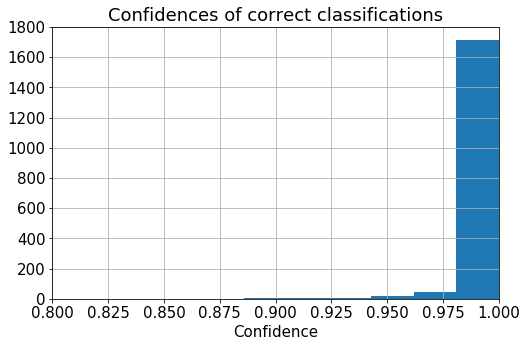

Lowest confidence of correct classifications: 0.8098
Highest (and only) confidence of incorrect classification: 0.6159


In [33]:
# Confidences of correct classifications
fig = plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 15})
plt.hist(confidences_correct)
plt.grid()
plt.xlim([0.80,1])
plt.title("Confidences of correct classifications")
plt.xlabel("Confidence")
plt.show(fig)
min_conf = np.amin(confidences_correct)
max_inc_conf = np.amax(confidences_incorrect)
print("Lowest confidence of correct classifications: {:.4f}".format(min_conf))
print("Highest (and only) confidence of incorrect classification: {:.4f}".format(max_inc_conf))

Text(0.5,1,'Accuracy score: 0.999')

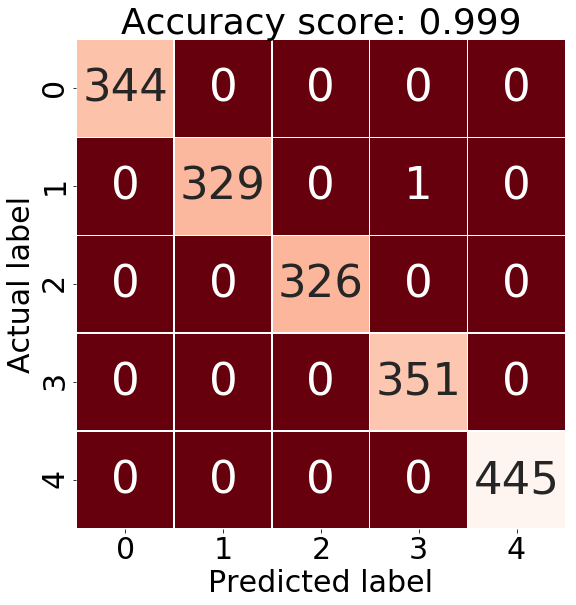

In [14]:
## Generating confusion matrix
cm = pd.DataFrame(metrics.confusion_matrix(list(y_test[:,3]), y_pred))

plt.rcParams['figure.figsize'] = (9.0,9.0)
plt.rcParams['font.size'] = 30
p = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, 
                square = True, cmap = 'Reds_r', 
                annot_kws={"size": 45}, cbar = False)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy score: {:.3f}'.format(acc), fontweight='roman')

In [15]:
# Scaling values from preprocessing to determine position on image
# From preprocessing
scale_x = 0.32995799331059017
scale_y = 0.23119611855851063
offset_x = 0.1389710275174676
offset_y = 0.10349845895745252+0.02
# From robot
diff_x = 0.51494
diff_y = 0.38178
# Pixels in image
px_x = 640
px_y = 480
# For angle
offset_th = 0.40011610405511
scale_th = 0.7997900962434958
align_th = 0.77

# To go from input/output values from network and to image coordinates
def net2im_x(x_net):
    global scale_x
    global offset_x
    global px_x
    global diff_x
    
    return int(px_x/2-(x_net*scale_x-offset_x)*px_x/diff_x)

def net2im_y(y_net):
    global scale_y
    global offset_y
    global px_y
    global diff_y
    
    return int((y_net*scale_y-offset_y)*px_y/diff_y+px_y/2)

def net2im_th(th_net):
    return (th_net*scale_th+offset_th-align_th)*2

In [16]:
# Converting RMSE values to other units

# To [m]
RMSExm = RMSEx*scale_x
RMSEym = RMSEy*scale_y
# To [mm]
RMSExmm = RMSExm*1000
RMSEymm = RMSEym*1000
# To [pixels]
RMSExpx = RMSExm*px_x/diff_x
RMSEypx = RMSEym*px_y/diff_y

# Angle [radians]
RMSEthr = RMSEth*scale_th*2
# to [degrees]
RMSEthd = math.degrees(RMSEthr)

print("(RMSEx , RMSEy)")
print("       [m] : ( {:.4f} , {:.4f} )".format(RMSExm,RMSEym))
print("      [mm] : ( {:.2f}   , {:.2f}   )".format(RMSExmm,RMSEymm))
print("      [px] : ( {:.1f}    , {:.1f}    )".format(RMSExpx,RMSEypx))
print("")
print("RMSEth")
print("     [rad] : {:.3f}".format(RMSEthr))
print("     [deg] : {:.3f}".format(RMSEthd))

(RMSEx , RMSEy)
       [m] : ( 0.0050 , 0.0036 )
      [mm] : ( 5.05   , 3.65   )
      [px] : ( 6.3    , 4.6    )

RMSEth
     [rad] : 0.039
     [deg] : 2.251


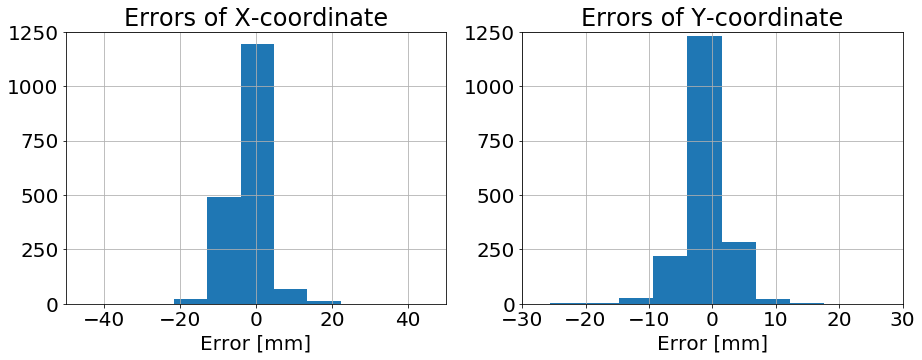

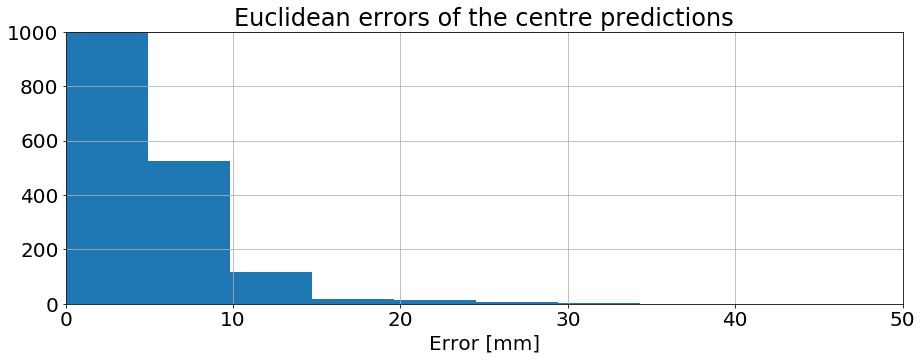

The coordinate errors have the following attributes:
X ranging in [-38.94,48.51] [mm]
Y ranging in [-25.58,28.49] [mm]
And with a 95% confidence the errors will be in the range:
X : -2.14 +/- 9.14 [mm]
Y : -0.88 +/- 7.08 [mm]
The maximum euclidean error for a centre prediction is: 48.953 [mm]


In [30]:
# Coordinate errors
x_err2 = np.zeros(shape=(len(x_err),1))
y_err2 = np.zeros(shape=(len(x_err),1))
euc_err2 = np.zeros(shape=(len(x_err),1))
# converting to [mm]
for i in range(len(x_err)):
    x_err2[i] = x_err[i]*scale_x*1000
    y_err2[i] = y_err[i]*scale_y*1000
    euc_err2[i] = math.sqrt(x_err2[i]**2+y_err2[i]**2)
fig = plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 20})
plt.subplot(1,2,1)
plt.title("Errors of X-coordinate")
plt.hist(x_err2)
plt.grid()
plt.ylim([0,1250])
plt.xlim([-50,50])
plt.xlabel("Error [mm]")
plt.subplot(1,2,2)
plt.title("Errors of Y-coordinate")
plt.hist(y_err2)
plt.grid()
plt.ylim([0,1250])
plt.xlim([-30,30])
plt.xlabel("Error [mm]")
plt.show(fig)

fig = plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 20})
plt.hist(euc_err2)
plt.grid()
plt.ylim([0,1000])
plt.xlim([0,50])
plt.title("Euclidean errors of the centre predictions")
plt.xlabel("Error [mm]")
plt.show(fig)

x_mean = np.mean(x_err2)
y_mean = np.mean(y_err2)
x_min = np.amin(x_err2)
y_min = np.amin(y_err2)
x_max = np.amax(x_err2)
y_max = np.amax(y_err2)
x_std = np.std(x_err2)
y_std = np.std(y_err2)
euc_max = np.amax(euc_err2)

print("The coordinate errors have the following attributes:")
print("X ranging in [{:.2f},{:.2f}] [mm]".format(x_min,x_max))
print("Y ranging in [{:.2f},{:.2f}] [mm]".format(y_min,y_max))
print("And with a 95% confidence the errors will be in the range:")
print("X : {:.2f} +/- {:.2f} [mm]".format(x_mean,2*x_std))
print("Y : {:.2f} +/- {:.2f} [mm]".format(y_mean,2*y_std))
print("The maximum euclidean error for a centre prediction is: {:.3f} [mm]".format(euc_max))

Predicted: pos = (0.7433,0.1367), angle = 0.3011, color = green with conf = 0.9985
Predicted center: (187 , 124)


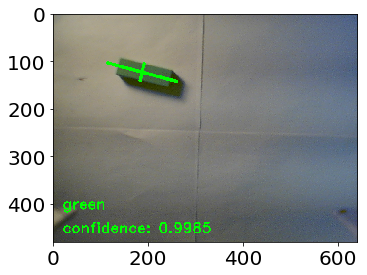

In [18]:
# Inputting to neural network
image_paths = glob.glob("pics/*/*.png")
n_images = len(image_paths)
idx = np.random.randint(n_images)
y_true = y[idx]
img_pil = Image.open(image_paths[idx])
# Preprocssing for NN
img_tensor = preprocess(img_pil)
img_tensor.unsqueeze_(0)
img_tensor_cuda = img_tensor.cuda()

outputs1, outputs2 = net(Variable(img_tensor_cuda))
conf, predicted = torch.max(outputs2.data, 1)
x_p = outputs1[0,0].item()
y_p = outputs1[0,1].item()
th_p = outputs1[0,2].item()
color_p = int(predicted.item())

# If using threshold
threshold = 0.0
if conf.item() < threshold:
    img_cv2 = np.array(img_pil)
    cv2.putText(img_cv2,"confidence: {:.4f} < {:.4f}".format(conf.item(),threshold),(20,410),font,fontScale,(0,255,0),lineType)
    cv2.putText(img_cv2,"Empty due to low confidence",(20,460),font,fontScale,(0,255,0),lineType)
else:
    print("Predicted: pos = ({:.4f},{:.4f}), angle = {:.4f}, color = {} with conf = {:.4f}".format(x_p,y_p,th_p,class_mapping[color_p],conf.item()))

    # Casting to numpy array and going to 128x128x3 again
    img_cv2 = np.array(img_pil)

    # Predicted position and angle
    X = net2im_x(x_p)
    Y = net2im_y(y_p)
    th = net2im_th(th_p)

    print("Predicted center: ({} , {})".format(X,Y))
    
    if not "empty" in class_mapping[color_p]:
        draw_lines(img_cv2,X,Y,th)
        
    # Text
    font = cv2.FONT_HERSHEY_DUPLEX
    fontScale = 1
    lineType = 2
    cv2.putText(img_cv2,class_mapping[color_p],(20,410),font,fontScale,(0,255,0),lineType)
    cv2.putText(img_cv2,"confidence: {:.4f}".format(conf.item()),(20,460),font,fontScale,(0,255,0),lineType)

fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_cv2)

In [19]:
# Save weights if desired
if save_weights:
    torch.save(net,weights_name)

In [20]:
time_start = time.time()

n = 1000

for i in range(n):
    idx = np.random.randint(n_images)
    img_pil = Image.open(image_paths[idx])
    # Preprocssing for NN
    img_tensor = preprocess(img_pil)
    img_tensor.unsqueeze_(0)
    img_tensor_cuda = img_tensor.cuda()

    outputs1, outputs2 = net(Variable(img_tensor_cuda))
    conf, predicted = torch.max(outputs2.data, 1)
    x_p = outputs1[0,0].item()
    y_p = outputs1[0,1].item()
    th_p = outputs1[0,2].item()
    color_p = int(predicted.item())

time_end = time.time()

diff = (time_end-time_start)/n
print("Time for one prediction: {:.4f}[s]".format(diff))
print("FPS: {:.2f}[frames/s]".format(1/diff))

Time for one prediction: 0.0174[s]
FPS: 57.43[frames/s]
